In [251]:
import numpy as np
import pickle
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import community

In [310]:
# load in data
with open('/Users/rohanramesh/Documents/SportsData/NBA/AllYearlyData_2008_2018.pickle', 'rb') as handle:
    df_all_stats = pickle.load(handle)

years_to_use = range(2008,2019)

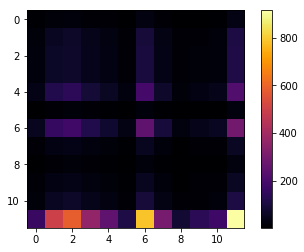

[117.5 347.5 405.  252.5 172.5  77.5 547.5 210.   57.5  97.5 125.  635. ]


(-0.5528953136489246,
 1.1133726774639374,
 -0.28539931773934785,
 0.340933479255482)

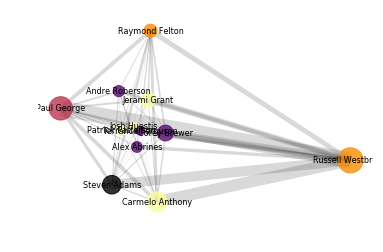

In [325]:
# Lets have team we play with be the GS Warriors in 2018
idx = (df_all_stats['2018']['Tm'] == "OKC") & (df_all_stats['2018']['MP_adv'] > 200)
GSW_team = df_all_stats['2018'][['Player','AST','PS/G','Pos']][idx]
# GSW_team = GSW_team.iloc[0:6]
# print(GSW_team)
curr_team_ast_pts = GSW_team[['AST', 'PS/G']].values
summed_ast_pts = curr_team_ast_pts.sum(axis=0)
# lets make a matrix of all pairwise comparisons
all_pairwise_edges = np.ndarray(shape= (np.shape(curr_team_ast_pts)[0],np.shape(curr_team_ast_pts)[0]))
# build the ratio for edges = (AST for a person / AST total) * (PTS for a person / PTS total)
for i in range(0,np.shape(curr_team_ast_pts)[0]):
    for j in range(0,np.shape(curr_team_ast_pts)[0]):
        all_pairwise_edges[i,j] = (100 * curr_team_ast_pts[i][0]/summed_ast_pts[0]) * (100 * curr_team_ast_pts[j][1]/summed_ast_pts[1])
# print(GSW_team)
cm = plt.get_cmap('inferno')
plt.imshow(all_pairwise_edges, cmap=cm)
plt.colorbar()
plt.show()

# for the nodes lets use player names
pnames = GSW_team['Player'].tolist()
curr_positions = GSW_team['Pos'].tolist()
unique_pos = list(set(curr_positions))
cm = plt.get_cmap('inferno',5) # 5 bc of the 5 positions
nodecolors = [cm.colors[j] for i in curr_positions for j in range(0,len(unique_pos)) if i == unique_pos[j]]
node_size_use = GSW_team['PS/G'] * 25
print(node_size_use.as_matrix())
G = nx.Graph()
G.add_nodes_from(pnames)
labels_use = {}
outward_vs_inward_direction = []
for i in range(0,np.shape(curr_team_ast_pts)[0]):
    labels_use[pnames[i]] = pnames[i]
    for j in range(i+1,np.shape(curr_team_ast_pts)[0]):
#         G.add_edge(pnames[i],pnames[j], weight= max([all_pairwise_edges[i,j], all_pairwise_edges[j,i]]) / 50)
        if all_pairwise_edges[i,j] > all_pairwise_edges[j,i]:
            G.add_edge(pnames[i],pnames[j], weight= all_pairwise_edges[i,j] / 50)
            outward_vs_inward_direction.append('k')
        elif all_pairwise_edges[j,i] > all_pairwise_edges[i,j]:
            G.add_edge(pnames[j],pnames[i], weight= all_pairwise_edges[j,i] / 50)
            outward_vs_inward_direction.append('k')

# # adding in the community clustering
# G2 = G.to_undirected()
# parts = community.best_partition(G2)
# nodeval = {node: parts.get(node) for node in G2.nodes()}
# ncommunities = len(np.unique([parts.get(node) for node in G2.nodes()]))
# print(ncommunities)
# G = G2
# arcs = nx.draw_networkx_edges(G, pos=nx.spring_layout(G))
pos = nx.kamada_kawai_layout(G)
# pos=nx.spring_layout(G, iterations=500)
# pos=nx.circular_layout(G)
edge_labels=dict([((u,v,),round(d['weight']))
                 for u,v,d in G.edges(data=True)])
# print(edge_labels)
edgewidth = [d['weight'] for (u, v, d) in G.edges(data=True)]
# # we can now added edge thickness and edge color
nx.draw_networkx_nodes(G, pos=pos, node_size=node_size_use, node_color=nodecolors,alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edgewidth, alpha=0.15, arrowstyle= 'simple', arrowsize=5, arrows=False,
                       edge_cmap=plt.cm.Greys,edge_color=outward_vs_inward_direction)
nx.draw_networkx_labels(G, pos, labels_use, font_size=8)
plt.axis('off')


In [344]:
# functions to build the Graphs
def build_graphs_each_team(df_all_stats,curr_year,curr_team):
    """ for any team on any particular year build a graph where all of the nodes are individual players 
    and the edges connecting players is a ratio between player A's relative assist rate and player B's
    relative scoring total. Each edge basically describes that pairs contribution to the teams scoring 
    at the level of assists and scoring
    ratio for edges = (100 * AST person A / AST total) * (100 * PS/G person B / PS/G total)"""
    idx = (df_all_stats[curr_year]['Tm'] == curr_team) & (df_all_stats[curr_year]['MP_adv'] > 200)
    Team_df = df_all_stats[curr_year][['Player','AST','PS/G','Pos']][idx]
    # print(GSW_team)
    curr_team_ast_pts = Team_df[['AST', 'PS/G']].values
    summed_ast_pts = curr_team_ast_pts.sum(axis=0)
    # lets make a matrix of all pairwise comparisons
    all_pairwise_edges = np.ndarray(shape= (np.shape(curr_team_ast_pts)[0],np.shape(curr_team_ast_pts)[0]))
    # build the ratio for edges = (100 * AST for a person / AST total) * (100 * PTS for a person / PTS total)
    for i in range(0,np.shape(curr_team_ast_pts)[0]):
        for j in range(0,np.shape(curr_team_ast_pts)[0]):
            all_pairwise_edges[i,j] = (100 * curr_team_ast_pts[i][0]/summed_ast_pts[0]) * (100 * curr_team_ast_pts[j][1]/summed_ast_pts[1])

    # for the nodes lets use player names
    pnames = Team_df['Player'].tolist()
    curr_positions = Team_df['Pos'].tolist()
    unique_pos = list(set(curr_positions))
    cm = plt.get_cmap('inferno',5) # 5 bc of the 5 positions
    nodecolors = [cm.colors[j] for i in curr_positions for j in range(0,len(unique_pos)) if i == unique_pos[j]]
    node_size_use = Team_df['PS/G'] * 25
    node_size_use = node_size_use.as_matrix()
    G = nx.Graph()
    G.add_nodes_from(pnames)
    # to save the PS/G for node size later
    points_per_game = {}
    for i in range(0,len(pnames)):
        points_per_game[pnames[i]] = node_size_use[i]
    nx.set_node_attributes(G, points_per_game, 'ppg')
    labels_use = {}
    outward_vs_inward_direction = []
    for i in range(0,np.shape(curr_team_ast_pts)[0]):
        labels_use[pnames[i]] = pnames[i]
        for j in range(i+1,np.shape(curr_team_ast_pts)[0]):
            if all_pairwise_edges[i,j] > all_pairwise_edges[j,i]:
                G.add_edge(pnames[i],pnames[j], weight= all_pairwise_edges[i,j] / 50)
                outward_vs_inward_direction.append('k')
            elif all_pairwise_edges[j,i] > all_pairwise_edges[i,j]:
                G.add_edge(pnames[j],pnames[i], weight= all_pairwise_edges[j,i] / 50)
                outward_vs_inward_direction.append('k')
    return G

def visualize_graph_for_team_year(G):
    """ visualize the graph """
    pos = nx.kamada_kawai_layout(G)
    # pos=nx.spring_layout(G, iterations=500)
    # pos=nx.circular_layout(G)
    edge_labels=dict([((u,v,),round(d['weight']))
                     for u,v,d in G.edges(data=True)])
    # for the node size
    node_size_use = nx.get_node_attributes(G,'ppg')
    node_array = [node_size_use[i] for i in list(node_size_use)]
    labels_use = {}
    for i in G.nodes():
        labels_use[i] = i
    # print(edge_labels)
    edgewidth = [d['weight'] for (u, v, d) in G.edges(data=True)]
    # # we can now added edge thickness and edge color
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_array, node_color=nodecolors,alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edgewidth, alpha=0.15, arrowstyle= 'simple', arrowsize=5, arrows=False,
                           edge_cmap=plt.cm.Greys)
    nx.draw_networkx_labels(G, pos, labels_use, font_size=8)
    plt.axis('off')

In [338]:
# iterate through all years and all teams and build all relevant graphs
list_of_teams_mult = df_all_stats['2018']['Tm']
all_teams = list_of_teams_mult.drop_duplicates().tolist()
all_team_graphs = {}
for curr_year in years_to_use[1:]:
    all_team_graphs[str(curr_year)] = {}
    for curr_team in all_teams:
        all_team_graphs[str(curr_year)][curr_team] = build_graphs_each_team(
            df_all_stats,str(curr_year),curr_team)
        
    

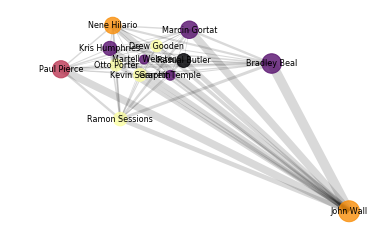

In [352]:
visualize_graph_for_team_year(all_team_graphs['2015']['WAS'])

In [359]:
G = all_team_graphs['2018']['GSW']
A = nx.algorithms.edge_betweenness_centrality(G)
print(G)

{('Jordan Bell', 'Omri Casspi'): 0.009523809523809525, ('Jordan Bell', 'Quinn Cook'): 0.009523809523809525, ('Jordan Bell', 'Stephen Curry'): 0.009523809523809525, ('Jordan Bell', 'Kevin Durant'): 0.009523809523809525, ('Jordan Bell', 'Draymond Green'): 0.009523809523809525, ('Jordan Bell', 'Andre Iguodala'): 0.009523809523809525, ('Jordan Bell', 'Shaun Livingston'): 0.009523809523809525, ('Jordan Bell', 'Kevon Looney'): 0.009523809523809525, ('Jordan Bell', 'Patrick McCaw'): 0.009523809523809525, ('Jordan Bell', 'JaVale McGee'): 0.009523809523809525, ('Jordan Bell', 'Zaza Pachulia'): 0.009523809523809525, ('Jordan Bell', 'Klay Thompson'): 0.009523809523809525, ('Jordan Bell', 'David West'): 0.009523809523809525, ('Jordan Bell', 'Nick Young'): 0.009523809523809525, ('Omri Casspi', 'Quinn Cook'): 0.009523809523809525, ('Omri Casspi', 'Stephen Curry'): 0.009523809523809525, ('Omri Casspi', 'Kevin Durant'): 0.009523809523809525, ('Omri Casspi', 'Draymond Green'): 0.009523809523809525, ('O

6.223311335403727
